In [11]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           balanced_accuracy_score, f1_score, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler
import joblib

# Advanced ML libraries
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available. Install with: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not available. Install with: pip install lightgbm")

# Explainability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available. Install with: pip install shap")

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"LightGBM available: {LIGHTGBM_AVAILABLE}")
print(f"SHAP available: {SHAP_AVAILABLE}")

Libraries imported successfully!
XGBoost available: True
LightGBM available: True
SHAP available: True


In [12]:
# Load preprocessed datasets
print("LOADING PREPROCESSED DATA")

try:
    # Load preprocessed datasets
    X_train = pd.read_csv('X_train_scaled.csv')
    X_val = pd.read_csv('X_val_scaled.csv')
    X_test = pd.read_csv('X_test_scaled.csv')
    
    y_train = pd.read_csv('y_train.csv').squeeze()
    y_val = pd.read_csv('y_val.csv').squeeze()
    y_test = pd.read_csv('y_test.csv').squeeze()
    ### The .squeeze() method removes dimensions of size 1, converting a DataFrame to a Series
    ### The .squeeze() method is a clean, robust way to ensure your target variables are in the correct 1D format that sklearn expects, 
    ### preventing potential errors during model training and evaluation.
    
    # Load preprocessing objects
    scaler = joblib.load('scaler.pkl')
    selected_features = joblib.load('selected_features.pkl')
    
    print("...Preprocessed data loaded successfully!!....")
    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")
    
    # Display class distribution
    print("\nClass distribution:")
    print("Training set:")
    print(y_train.value_counts().sort_index())
    print("\nValidation set:")
    print(y_val.value_counts().sort_index())
    print("\nTest set:")
    print(y_test.value_counts().sort_index())
    
    # Display selected features
    print(f"\nSelected features ({len(selected_features)}):")
    for i, feature in enumerate(selected_features, 1):
        print(f"{i:2d}. {feature}")
        
except FileNotFoundError as e:
    print(f"Error loading preprocessed data: {e}")
    print("Please run the preprocessing notebook first to generate the required files.")
    print("Required files: X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv")
    print("                y_train.csv, y_val.csv, y_test.csv")
    print("                scaler.pkl, selected_features.pkl")


LOADING PREPROCESSED DATA
...Preprocessed data loaded successfully!!....
Training set: (368, 10)
Validation set: (123, 10)
Test set: (123, 10)

Class distribution:
Training set:
Loan_Status
0    115
1    253
Name: count, dtype: int64

Validation set:
Loan_Status
0    39
1    84
Name: count, dtype: int64

Test set:
Loan_Status
0    38
1    85
Name: count, dtype: int64

Selected features (10):
 1. CoapplicantIncome
 2. LoanAmount
 3. Loan_Amount_Term
 4. ApplicantIncome
 5. ApplicantIncome_log
 6. CoapplicantIncome_log
 7. LoanAmount_log
 8. Loan_Amount_Term_log
 9. LA_to_IN_ratio
10. Total_Income


#### **2. Baseline Model - Logistic Regression**

In [13]:
# Baseline Logistic Regression model
print("BASELINE LOGISTIC REGRESSION MODEL")
print("EDA recommendation: Fast, interpretable baseline with coefficients for feature effect direction")

# Create and train baseline model
baseline_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'  # Handle class imbalance as recommended by EDA
)

# Train the model
baseline_model.fit(X_train, y_train)

# Make predictions
y_train_pred = baseline_model.predict(X_train)
y_val_pred = baseline_model.predict(X_val)
y_test_pred = baseline_model.predict(X_test)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
val_balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred, average='macro')
val_f1 = f1_score(y_val, y_val_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"\nBaseline Model Performance:")
print(f"Training - Accuracy: {train_accuracy:.3f}, Balanced Acc: {train_balanced_acc:.3f}, Macro F1: {train_f1:.3f}")
print(f"Validation - Accuracy: {val_accuracy:.3f}, Balanced Acc: {val_balanced_acc:.3f}, Macro F1: {val_f1:.3f}")
print(f"Test - Accuracy: {test_accuracy:.3f}, Balanced Acc: {test_balanced_acc:.3f}, Macro F1: {test_f1:.3f}")

# Display feature coefficients (interpretability)
print(f"\nFeature Coefficients (Top 10):")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': baseline_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['coefficient']:.3f}")

# Store baseline results
baseline_results = {
    'model': 'Logistic Regression',
    'train_accuracy': train_accuracy,
    'val_accuracy': val_accuracy,
    'test_accuracy': test_accuracy,
    'train_balanced_acc': train_balanced_acc,
    'val_balanced_acc': val_balanced_acc,
    'test_balanced_acc': test_balanced_acc,
    'train_f1': train_f1,
    'val_f1': val_f1,
    'test_f1': test_f1
}

print(".... Baseline model completed!")


BASELINE LOGISTIC REGRESSION MODEL
EDA recommendation: Fast, interpretable baseline with coefficients for feature effect direction

Baseline Model Performance:
Training - Accuracy: 0.560, Balanced Acc: 0.573, Macro F1: 0.545
Validation - Accuracy: 0.561, Balanced Acc: 0.596, Macro F1: 0.554
Test - Accuracy: 0.537, Balanced Acc: 0.534, Macro F1: 0.515

Feature Coefficients (Top 10):
 1. LoanAmount_log: -0.481
 2. ApplicantIncome_log: 0.201
 3. CoapplicantIncome_log: 0.090
 4. Loan_Amount_Term_log: -0.057
 5. LA_to_IN_ratio: -0.028
 6. LoanAmount: 0.003
 7. Loan_Amount_Term: 0.001
 8. CoapplicantIncome: -0.000
 9. Total_Income: -0.000
10. ApplicantIncome: 0.000
.... Baseline model completed!


#### **3. Random Forest Classifier (EDA Recommendation)**

RANDOM FOREST CLASSIFIER
EDA recommendation: Robust, captures interactions, insensitive to scaling and moderate outliers

Random Forest Performance:
Training - Accuracy: 1.000, Balanced Acc: 1.000, Macro F1: 1.000
Validation - Accuracy: 0.593, Balanced Acc: 0.489, Macro F1: 0.482
Test - Accuracy: 0.650, Balanced Acc: 0.558, Macro F1: 0.559

Feature Importance (Top 10):
 1. LA_to_IN_ratio: 0.163
 2. Total_Income: 0.150
 3. ApplicantIncome_log: 0.139
 4. ApplicantIncome: 0.132
 5. LoanAmount_log: 0.115
 6. LoanAmount: 0.113
 7. CoapplicantIncome: 0.072
 8. CoapplicantIncome_log: 0.071
 9. Loan_Amount_Term_log: 0.025
10. Loan_Amount_Term: 0.021


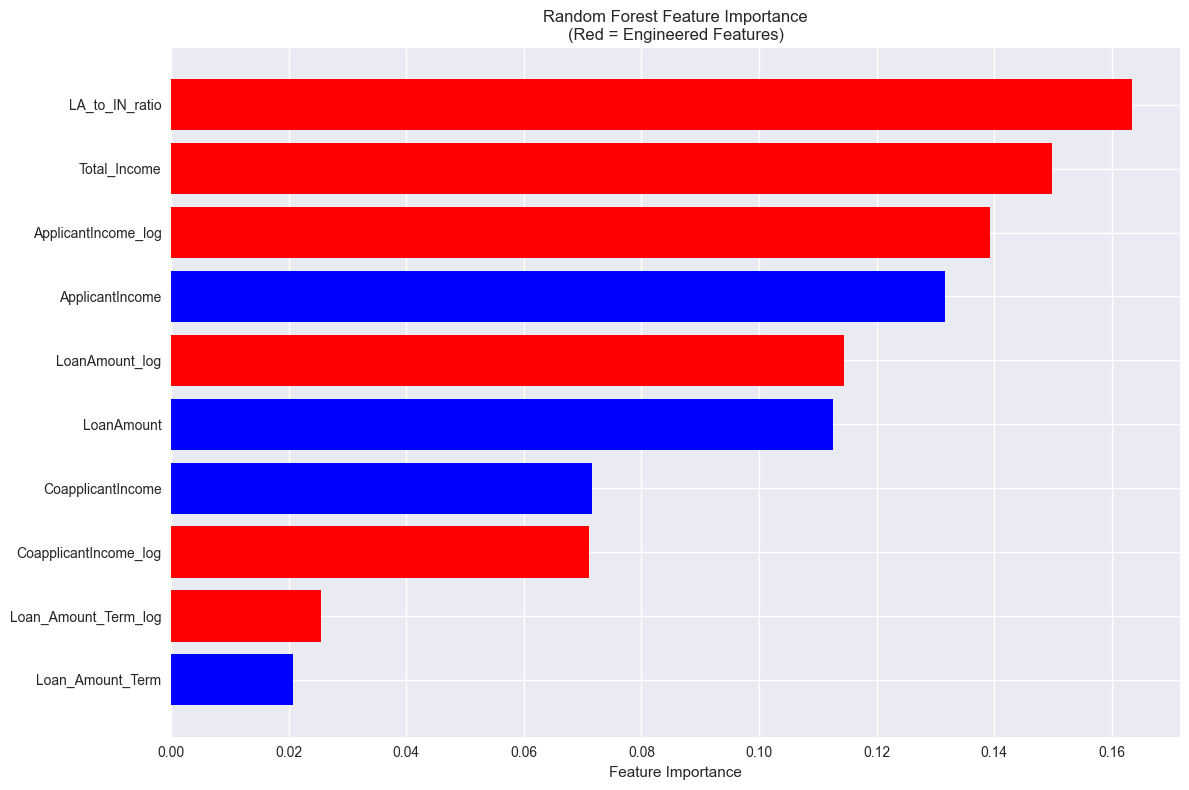

....Random Forest model completed...!


In [14]:
# Random Forest Classifier
print("RANDOM FOREST CLASSIFIER")
print("EDA recommendation: Robust, captures interactions, insensitive to scaling and moderate outliers")

# Create Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    n_jobs=-1  # Use all available cores
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)

# Calculate metrics
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

train_balanced_acc_rf = balanced_accuracy_score(y_train, y_train_pred_rf)
val_balanced_acc_rf = balanced_accuracy_score(y_val, y_val_pred_rf)
test_balanced_acc_rf = balanced_accuracy_score(y_test, y_test_pred_rf)

train_f1_rf = f1_score(y_train, y_train_pred_rf, average='macro')
val_f1_rf = f1_score(y_val, y_val_pred_rf, average='macro')
test_f1_rf = f1_score(y_test, y_test_pred_rf, average='macro')

print(f"\nRandom Forest Performance:")
print(f"Training - Accuracy: {train_accuracy_rf:.3f}, Balanced Acc: {train_balanced_acc_rf:.3f}, Macro F1: {train_f1_rf:.3f}")
print(f"Validation - Accuracy: {val_accuracy_rf:.3f}, Balanced Acc: {val_balanced_acc_rf:.3f}, Macro F1: {val_f1_rf:.3f}")
print(f"Test - Accuracy: {test_accuracy_rf:.3f}, Balanced Acc: {test_balanced_acc_rf:.3f}, Macro F1: {test_f1_rf:.3f}")

# Feature importance analysis
print(f"\nFeature Importance (Top 10):")
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

for i, (_, row) in enumerate(feature_importance_rf.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['importance']:.3f}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features_rf = feature_importance_rf.head(15)
colors = ['red' if any(keyword in f.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log']) else 'blue' for f in top_features_rf['feature']]

plt.barh(range(len(top_features_rf)), top_features_rf['importance'], color=colors)
plt.yticks(range(len(top_features_rf)), top_features_rf['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance\n(Red = Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Store Random Forest results
rf_results = {
    'model': 'Random Forest',
    'train_accuracy': train_accuracy_rf,
    'val_accuracy': val_accuracy_rf,
    'test_accuracy': test_accuracy_rf,
    'train_balanced_acc': train_balanced_acc_rf,
    'val_balanced_acc': val_balanced_acc_rf,
    'test_balanced_acc': test_balanced_acc_rf,
    'train_f1': train_f1_rf,
    'val_f1': val_f1_rf,
    'test_f1': test_f1_rf
}

print("....Random Forest model completed...!")
